Modifications to the simple Method


In [39]:
import phate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.graph_objects as go
from Python_Scripts.Data_Selection import *
from Python_Scripts.Data_Selection_for_BD import *
from matplotlib.colors import ListedColormap
from sklearn.metrics import pairwise_distances

In [57]:
# Load CSV into a DataFrame
file = '/Users/amittaris/Documents/GitHub/Dimensionality-Reduction-for-Cellular-Differentiation-/DR notebooks/PHATE/datasets/df_facs_decision1.csv'
data = pd.read_csv(file)

# Display the first few rows of the data
print(data.head())

   Unnamed: 0  cellidx      TBX6       BRA      CDX2      SOX2      SOX1  \
0           0        0  0.541198  0.228724  1.136731  2.638387  0.676792   
1           1        1  0.562709  0.153176  1.251472  0.776583  0.694261   
2           2        2  0.637590  0.240679  1.486664  3.752942  0.682324   
3           3        3  0.640359  0.184531  1.614646  4.068103  0.828319   
4           4        4  0.639919  0.153728  1.823096  2.079683  0.990685   

                   filename  timepoint  sample  cluster_assignment_corrected  \
0  D2.5_A2_A02_003.fcs .csv        2.5       0                             0   
1  D2.5_A2_A02_003.fcs .csv        2.5       0                             0   
2  D2.5_A2_A02_003.fcs .csv        2.5       0                             0   
3  D2.5_A2_A02_003.fcs .csv        2.5       0                             0   
4  D2.5_A2_A02_003.fcs .csv        2.5       0                             0   

   cluster_post_replacement  synthetic  
0                    

In [58]:
# Step 1: Drop irrelevant columns
genes = data.drop(data.columns[[0, 1, 7, 9, 10]], axis=1)

# Step 2: Filter for valid timepoints
valid_timepoints_for_1 = [2.0, 2.5, 3.0, 3.5]
filtered_df = genes[genes['timepoint'].isin(valid_timepoints_for_1)]

amount_desired = 6000000

# Step 3: Select up to 2000 samples from each desired cluster
cell_types_0 = filtered_df[filtered_df['cluster_post_replacement'] == 0][:amount_desired]
cell_types_1 = filtered_df[filtered_df['cluster_post_replacement'] == 1][:amount_desired]
cell_types_2 = filtered_df[filtered_df['cluster_post_replacement'] == 2][:amount_desired]
cell_types_3 = filtered_df[filtered_df['cluster_post_replacement'] == 3][:amount_desired]

# Step 4: Combine selected data
combination_of_data = pd.concat(
    [cell_types_0, cell_types_1, cell_types_2, cell_types_3],
    axis=0
).reset_index(drop=True)

# Step 5: Prepare PHATE input (drop timepoint and cluster labels)
phate_data = filtered_df.drop(
    filtered_df.columns[[5, 6, 7]], axis=1
)

print(len(phate_data))

86400


In [59]:
#I am doing an embedding on only the first decision but it may be more useful to consider the whole framework firstly and then color the binary decisions 
phate_op = phate.PHATE(
    random_state=42,
    knn=15,           # slightly larger neighborhood to stabilize the graph
    decay=200,         # good balance of locality
    t='auto',    # high diffusion time for smooth trajectories
)

# Slice the first 8000 rows
embedding_2D = phate_op.fit_transform(phate_data)




Calculating PHATE...
  Running PHATE on 86400 observations and 5 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 10.44 seconds.
    Calculating affinities...
    Calculated affinities in 0.39 seconds.
  Calculated graph and diffusion operator in 10.88 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 6.70 seconds.
    Calculating KMeans...
    Calculated KMeans in 6.07 seconds.
  Calculated landmark operator in 14.13 seconds.
  Calculating optimal t...
    Automatically selected t = 23
  Calculated optimal t in 4.28 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.77 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.55 seconds.
Calculated PHATE in 32.63 seconds.


[[0.08705538 0.         0.         ... 0.         0.         0.        ]
 [0.         0.07801255 0.         ... 0.         0.         0.        ]
 [0.         0.         0.14146564 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.10545489 0.         0.        ]
 [0.         0.         0.         ... 0.         0.08426097 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15042868]]


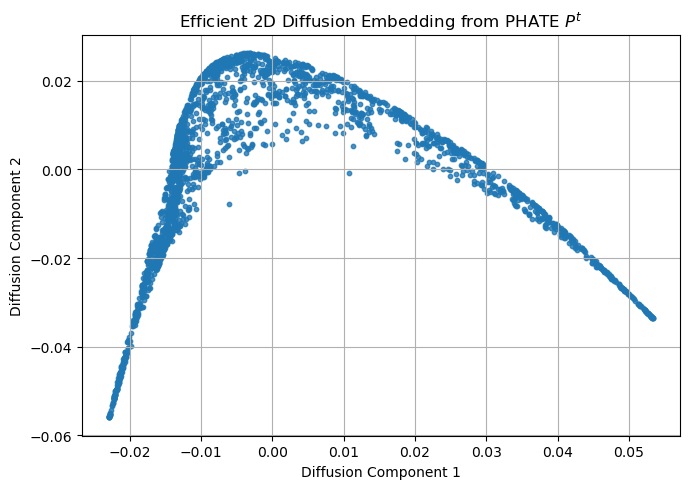

In [48]:
from scipy.sparse.linalg import eigs  # sparse and partial eigendecomposition

# Extract diffusion operator P
P = phate_op.diff_op

print(P)

# Efficient power operation through matrix-vector multiplication
def matvec_power(v):
    x = v
    for _ in range(phate_op.t):
        x = P @ x
    return x

# Wrap in a linear operator to avoid explicit P^t
from scipy.sparse.linalg import LinearOperator

n = P.shape[0]
P_t_linop = LinearOperator((n, n), matvec=matvec_power, dtype=np.float64)

# Get top 3 eigenpairs of P^t (skip the trivial 1st)
eigvals, eigvecs = eigs(P_t_linop, k=3, which='LR')  # 'LR' = largest real part

# Sort and take real part
idx = np.argsort(-np.abs(eigvals))
eigvals = eigvals[idx].real
eigvecs = eigvecs[:, idx].real

# Create 2D embedding
embedding_2D = eigvecs[:, 1:3] * eigvals[1:3]

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))
plt.scatter(embedding_2D[:, 0], embedding_2D[:, 1], s=10, alpha=0.8)
plt.title("Efficient 2D Diffusion Embedding from PHATE $P^t$")
plt.xlabel("Diffusion Component 1")
plt.ylabel("Diffusion Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


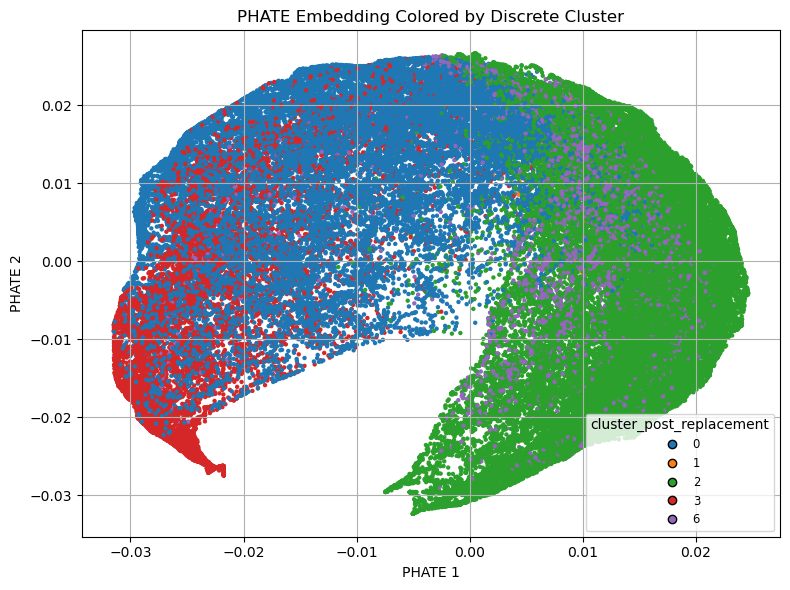

In [62]:
# 1. Extract cluster labels
clusters = filtered_df['cluster_post_replacement'].values
unique_clusters = sorted(np.unique(clusters))  # Ensure consistent ordering

# 2. Map each cluster to an index
cluster_to_code = {cluster: i for i, cluster in enumerate(unique_clusters)}
color_codes = np.array([cluster_to_code[c] for c in clusters])

# 3. Define a custom color palette
custom_cmap = ListedColormap([
    "#1f77b4",  # dark blue
    "#ff7f0e",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
    "#9467bd",  # purple
    "#8c564b",  # brown
    "#e377c2",  # pink
    "#7f7f7f",  # gray
    "#bcbd22",  # yellow-green
    "#17becf"   # cyan
][:len(unique_clusters)])  # truncate if fewer than 10 clusters

# 4. Plot PHATE embedding with discrete colors
plt.figure(figsize=(8, 6))
plt.scatter(
    embedding_2D[:, 0], embedding_2D[:, 1],
    c=color_codes,
    cmap=custom_cmap,
    s=10,
    alpha=1.0,
    edgecolors='none'
)

# 5. Custom legend (color matched to cluster label)
handles = [
    plt.Line2D([], [], marker='o', linestyle='',
               label=str(cluster),
               markerfacecolor=custom_cmap(code),
               markeredgecolor='k',
               markersize=6)
    for cluster, code in cluster_to_code.items()
]

plt.legend(handles=handles, title='cluster_post_replacement', loc='best', fontsize='small')
plt.title('PHATE Embedding Colored by Discrete Cluster')
plt.xlabel('PHATE 1')
plt.ylabel('PHATE 2')
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt

# --- Step 0: Assume these are already defined ---
# embedding_2D: (n_samples, 2) - your intrinsic manifold coords (from PHATE eigendecomposition)
# X: (n_samples, 5) - your high-dimensional data

# Simulate them here for demo purposes — replace with real values

# --- Step 1: Define decoder model: R^2 → R^5 ---
latent_input = layers.Input(shape=(2,))
x = layers.Dense(64, activation='relu')(latent_input)
x = layers.Dense(128, activation='relu')(x)
x_output = layers.Dense(5)(x)

decoder = Model(inputs=latent_input, outputs=x_output)

# --- Step 2: Define custom loss with distance preservation ---
def distance_preserving_loss(x_true, x_pred, z_batch, lambda_dist=1.0):
    # Reconstruction loss
    recon_loss = tf.reduce_mean(tf.square(x_true - x_pred))

    # Pairwise distances in latent and decoded spaces
    z_dist = tf.norm(tf.expand_dims(z_batch, axis=1) - tf.expand_dims(z_batch, axis=0), axis=-1)
    x_dist = tf.norm(tf.expand_dims(x_pred, axis=1) - tf.expand_dims(x_pred, axis=0), axis=-1)

    # Distance preservation loss
    dist_loss = tf.reduce_mean(tf.square(x_dist - z_dist))

    return recon_loss + lambda_dist * dist_loss

# --- Step 3: Custom training loop ---
optimizer = tf.keras.optimizers.Adam()
loss_history = []

z_tensor = tf.convert_to_tensor(embedding_2D, dtype=tf.float32)
x_tensor = tf.convert_to_tensor(phate_data, dtype=tf.float32)

for epoch in range(50):
    with tf.GradientTape() as tape:
        x_pred = decoder(z_tensor)
        loss = distance_preserving_loss(x_tensor, x_pred, z_tensor, lambda_dist=1.0)
    grads = tape.gradient(loss, decoder.trainable_weights)
    optimizer.apply_gradients(zip(grads, decoder.trainable_weights))
    loss_history.append(loss.numpy())




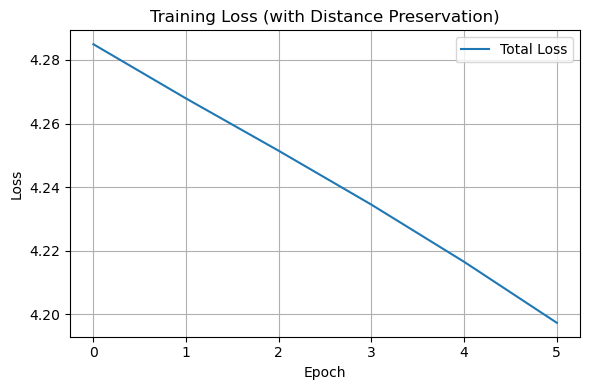

In [8]:

# --- Step 4: Plot training loss ---
plt.figure(figsize=(6, 4))
plt.plot(loss_history, label="Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss (with Distance Preservation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


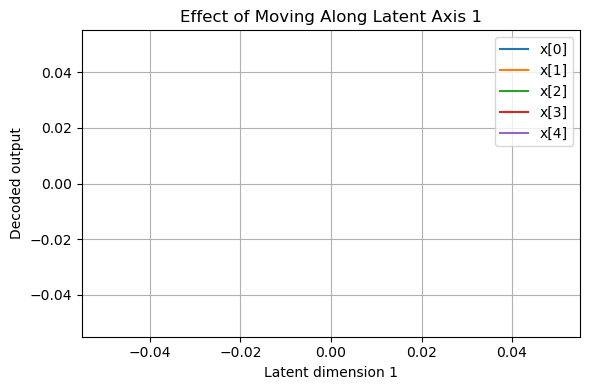

In [9]:
# --- Step 5: Plot decoded variation along latent axis 1 ---
z_grid = np.linspace(-3, 3, 100)
z_probe = np.stack([z_grid, np.zeros_like(z_grid)], axis=1)
decoded = decoder.predict(z_probe)

plt.figure(figsize=(6, 4))
for i in range(5):
    plt.plot(z_grid, decoded[:, i], label=f"x[{i}]")
plt.xlabel("Latent dimension 1")
plt.ylabel("Decoded output")
plt.title("Effect of Moving Along Latent Axis 1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
# --- Step 6: Jacobian at a single point ---
z_sample = tf.convert_to_tensor(embedding_2D[:1], dtype=tf.float32)  # first point
with tf.GradientTape() as tape:
    tape.watch(z_sample)
    x_decoded = decoder(z_sample)
jacobian = tape.batch_jacobian(x_decoded, z_sample)

print("Decoded 5D vector:", x_decoded.numpy())
print("Jacobian shape:", jacobian.shape)  # Should be (1, 5, 2)

Decoded 5D vector: [[nan nan nan nan nan]]
Jacobian shape: (1, 5, 2)


In [11]:
print(phate_data[:1])
print(embedding_2D[:1])

       TBX6       BRA      CDX2      SOX2      SOX1
0  0.541198  0.228724  1.136731  2.638387  0.676792
[[-0.01067035 -0.02044539]]


In [12]:
predicted_x = decoder.predict(embedding_2D[:1])
print(predicted_x)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[[nan nan nan nan nan]]


# Linear Regression Idea

In [4]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Suppose these are your data matrices
X = phate_data
Y = embedding_2D

# Train two models: one for PHATE1, one for PHATE2
model1 = LinearRegression()
model2 = LinearRegression()

model1.fit(X, Y[:, 0])
model2.fit(X, Y[:, 1])

# Print coefficients for interpretation
print("PHATE1 ~", model1.coef_, "Intercept:", model1.intercept_)
print("PHATE2 ~", model2.coef_, "Intercept:", model2.intercept_)

# Optionally: show R² scores to assess fit
phate1_pred = model1.predict(X)
phate2_pred = model2.predict(X)

print("R² PHATE1:", r2_score(Y[:, 0], phate1_pred))
print("R² PHATE2:", r2_score(Y[:, 1], phate2_pred))


NameError: name 'embedding_2D' is not defined

# Polynomial Fit

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

def fit_interpretable_poly_models(X, Y, feature_names=None, degree=3):
    if feature_names is None:
        feature_names = [f'x{i}' for i in range(X.shape[1])]

    # Train-test split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

    # Fit polynomial regression for a and b
    poly_model_a = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly_model_b = make_pipeline(PolynomialFeatures(degree), LinearRegression())

    poly_model_a.fit(X_train, Y_train[:, 0])
    poly_model_b.fit(X_train, Y_train[:, 1])

    # Predictions on test set
    a_pred_test = poly_model_a.predict(X_test)
    b_pred_test = poly_model_b.predict(X_test)

    # Predictions on train set
    a_pred_train = poly_model_a.predict(X_train)
    b_pred_train = poly_model_b.predict(X_train)

    # Evaluation metrics
    metrics = {
        'mse_a_test': mean_squared_error(Y_test[:, 0], a_pred_test),
        'r2_a_test': r2_score(Y_test[:, 0], a_pred_test),
        'mse_b_test': mean_squared_error(Y_test[:, 1], b_pred_test),
        'r2_b_test': r2_score(Y_test[:, 1], b_pred_test),
        'mse_a_train': mean_squared_error(Y_train[:, 0], a_pred_train),
        'r2_a_train': r2_score(Y_train[:, 0], a_pred_train),
        'mse_b_train': mean_squared_error(Y_train[:, 1], b_pred_train),
        'r2_b_train': r2_score(Y_train[:, 1], b_pred_train)
    }

    # Interpretable feature names and coefficients
    poly = PolynomialFeatures(degree)
    poly.fit(pd.DataFrame(X, columns=feature_names))
    expanded_feature_names = poly.get_feature_names_out(feature_names)

    coef_a = poly_model_a.named_steps['linearregression'].coef_
    intercept_a = poly_model_a.named_steps['linearregression'].intercept_

    coef_b = poly_model_b.named_steps['linearregression'].coef_
    intercept_b = poly_model_b.named_steps['linearregression'].intercept_

    formula_a = pd.Series(coef_a, index=expanded_feature_names)
    formula_b = pd.Series(coef_b, index=expanded_feature_names)

    return {
        'model_a': poly_model_a,
        'model_b': poly_model_b,
        'a_pred_test': a_pred_test,
        'b_pred_test': b_pred_test,
        'a_pred_train': a_pred_train,
        'b_pred_train': b_pred_train,
        'metrics': metrics,
        'formula_a': formula_a,
        'intercept_a': intercept_a,
        'formula_b': formula_b,
        'intercept_b': intercept_b,
        'feature_names': expanded_feature_names,
        'X_train': X_train,
        'Y_train': Y_train,
        'X_test': X_test,
        'Y_test': Y_test
    }


In [68]:
X = phate_data
Y = embedding_2D

result = fit_interpretable_poly_models(X, Y, feature_names=[ 'TBX6', 'BRA', 'CDX2', 'SOX2', 'SOX1'], degree=8)

# Print test scores
print("R² on test (a):", result['metrics']['r2_a_test'])
print("R² on test (b):", result['metrics']['r2_b_test'])
print("R² on train (a):", result['metrics']['r2_a_train'])
print("R² on train (b):", result['metrics']['r2_b_train'])

# Print interpretable formula
print(result['formula_a'].sort_values(ascending=False).head())



R² on test (a): 0.9393246171308945
R² on test (b): 0.915748755904199
R² on train (a): 0.9978348786585882
R² on train (b): 0.9981887057993122
TBX6^3 SOX1^3         0.415242
TBX6^4 SOX1           0.333564
TBX6^3                0.219877
TBX6^3 BRA SOX2       0.214215
TBX6 BRA SOX2 SOX1    0.168384
dtype: float64


In [ ]:
# Re-import necessary libraries after code state reset
import numpy as np
import matplotlib.pyplot as plt

def plot_poly_vs_phate(result, phate_embedding, sample_size=5000):
    """
    Compare the polynomial model predictions with PHATE embeddings.

    Parameters:
    - result: output from fit_interpretable_poly_models
    - phate_embedding: true PHATE 2D coordinates, shape (n_samples, 2)
    - sample_size: number of points to plot for readability
    """
    # Reconstruct full predictions on all X
    X_full = np.vstack((result['X_train'], result['X_test']))
    a_full = np.concatenate((result['a_pred_train'], result['a_pred_test']))
    b_full = np.concatenate((result['b_pred_train'], result['b_pred_test']))
    Y_pred_full = np.vstack((a_full, b_full)).T

    # Randomly sample indices to avoid overcrowded plots
    indices = np.random.choice(len(X_full), size=min(sample_size, len(X_full)), replace=False)

    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    axs[0].scatter(phate_embedding[indices, 0], phate_embedding[indices, 1], alpha=0.6, s=10)
    axs[0].set_title("Original PHATE embedding")
    axs[0].set_xlabel("PHATE 1")
    axs[0].set_ylabel("PHATE 2")

    axs[1].scatter(Y_pred_full[indices, 0], Y_pred_full[indices, 1], alpha=0.6, s=10, color='green')
    axs[1].set_title("Polynomial Regression Approximation")
    axs[1].set_xlabel("Predicted a")
    axs[1].set_ylabel("Predicted b")

    plt.tight_layout()
    plt.show()


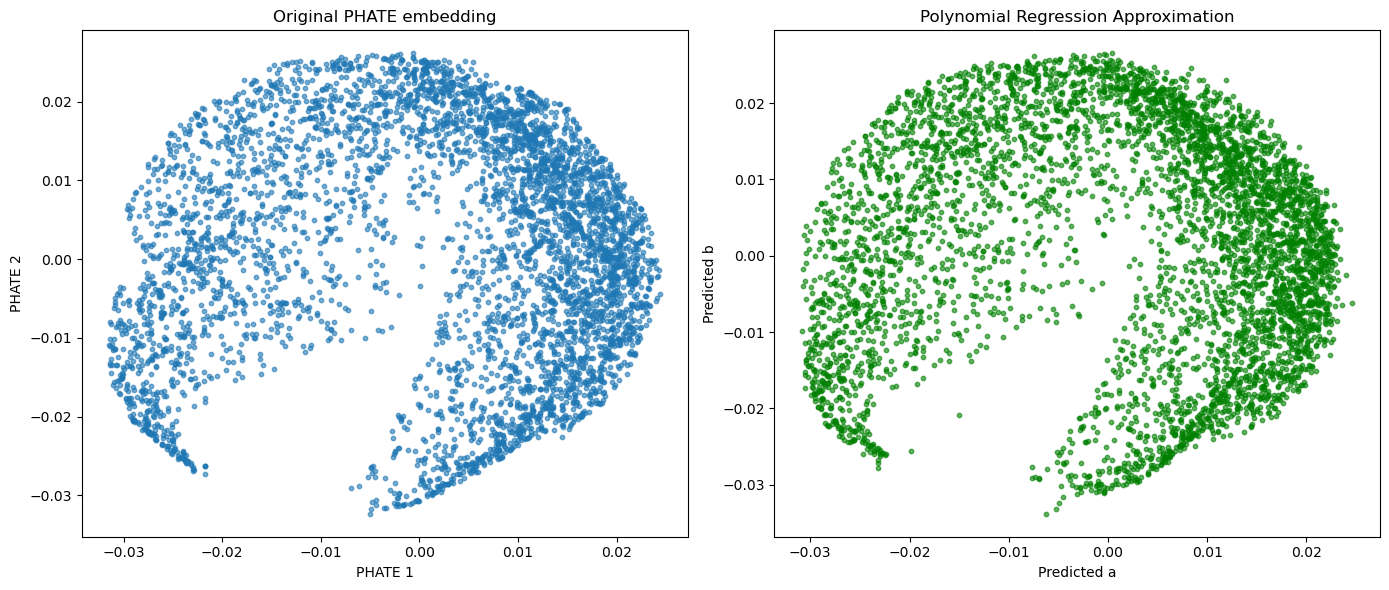

In [70]:
plot_poly_vs_phate(result, embedding_2D)


In [ ]:
import jax
import jax.numpy as jnp
import numpy as np

def build_jax_polynomial_function(coefs, intercept, powers):
    """
    Build a JAX-compatible multivariate polynomial function.
    """
    coefs = jnp.array(coefs)
    powers = jnp.array(powers)

    def f(x):
        x = jnp.asarray(x)
        terms = jnp.prod(x ** powers, axis=1)  # shape: (n_terms,)
        return jnp.dot(coefs, terms) + intercept

    return f


In [89]:
def compute_riemannian_metric_jax(result, X, feature_names):
    """
    Compute Riemannian metric G = JᵀJ for 2D embedding fitted from 5D input.
    
    Parameters:
        - result: output from fit_interpretable_poly_models
        - X: (n_samples, 5) gene expression array
        - feature_names: list of 5 strings (e.g., ['TBX6', ...])

    Returns:
        - List of (5x5) Riemannian metrics (one per point)
    """
    # Get powers from PolynomialFeatures
    poly = result['model_a'].named_steps['polynomialfeatures']
    powers = poly.powers_  # shape: (n_terms, 5)

    # Convert formula Series to numpy arrays
    coef_a = result['formula_a'].to_numpy()
    coef_b = result['formula_b'].to_numpy()
    intercept_a = result['intercept_a']
    intercept_b = result['intercept_b']

    # Build JAX functions
    f1 = build_jax_polynomial_function(coef_a, intercept_a, powers)
    f2 = build_jax_polynomial_function(coef_b, intercept_b, powers)

    # Vector-valued function
    def f_vec(x):
        return jnp.array([f1(x), f2(x)])

    jac_fn = jax.jacfwd(f_vec)

    metrics = []
    for i in range(X.shape[0]):
        J = jac_fn(jnp.array(X[i]))
        G = J.T @ J
        metrics.append(np.array(G))

    return metrics

In [ ]:
X_array = np.asarray(X)  # If it's not already
metrics = compute_riemannian_metric_jax(
    result,
    X_array,
    feature_names=['TBX6', 'BRA', 'CDX2', 'SOX2', 'SOX1']
)
print("Riemannian metric at first point:\n", metrics[0])




# Linear GAM


In [34]:
from pygam import LinearGAM, s
import numpy as np

# Fit a GAM for each coordinate (e.g., a and b in PHATE)
gam_a = LinearGAM(s(0) +s(1) + s(2) + s(3) + s(4)).fit(X, Y[:, 0])
gam_b = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4)).fit(X, Y[:, 1])


In [35]:
from sklearn.metrics import r2_score

a_pred = gam_a.predict(X)
b_pred = gam_b.predict(X)

print("R² for a:", r2_score(Y[:, 0], a_pred))
print("R² for b:", r2_score(Y[:, 1], b_pred))


R² for a: 0.9152086732990771
R² for b: 0.9062888341504136


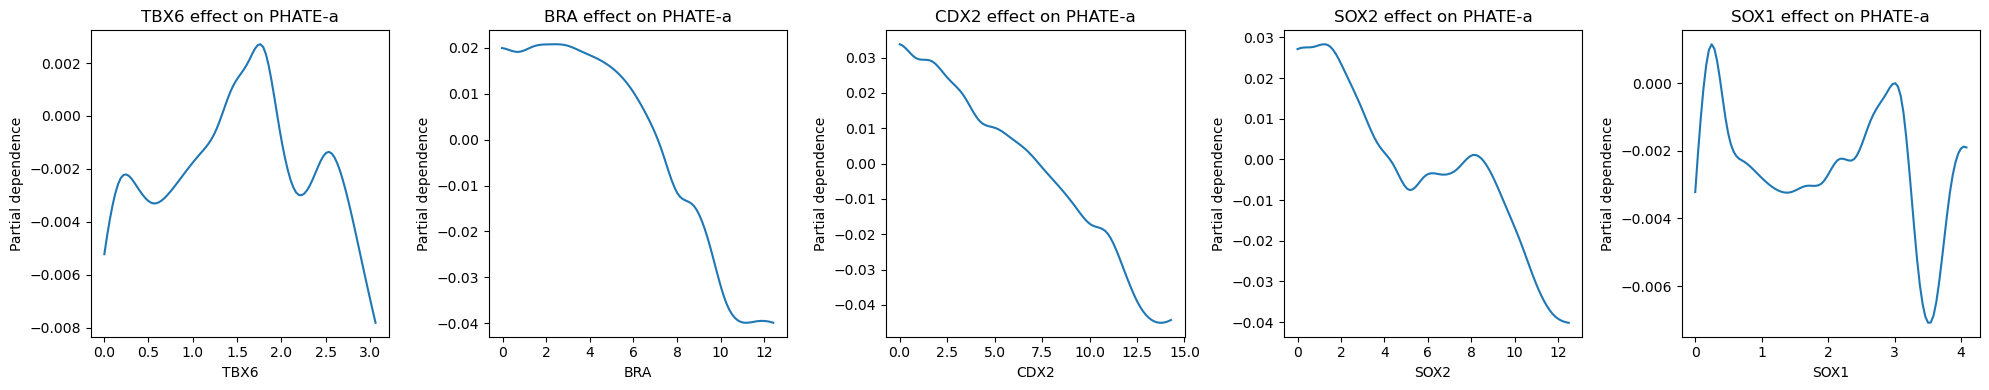

In [36]:
# Visualize smooth functions (gene effects)

gene_names = ['TBX6', 'BRA', 'CDX2', 'SOX2', 'SOX1']


fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, ax in enumerate(axes):
    XX = gam_a.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam_a.partial_dependence(term=i, X=XX))
    ax.set_title(f"{gene_names[i]} effect on PHATE-a")
    ax.set_xlabel(gene_names[i])
    ax.set_ylabel("Partial dependence")

plt.tight_layout()
plt.show()


In [50]:
from pygam import LinearGAM, s
import numpy as np
import pandas as pd

# Gene names expected in X
gene_names = ['TBX6', 'BRA', 'CDX2', 'SOX2', 'SOX1']

# Ensure X has shape (n_samples, 5); adjust if needed
if X.shape[1] == 1 and X.shape[0] == len(gene_names):
    X = X.T  # Transpose if shape is (5, n_samples)

# Create DataFrame from X with gene names
df = pd.DataFrame(X, columns=gene_names)

# Add empty columns if the next part requires them but they're not present
for g in ['OTX2', 'FOXC2']:
    if g not in df.columns:
        df[g] = np.nan  # Fill with NaNs (you can replace later with actual data if you have it)

# Define gene pairs to model (related genes from your image)
gene_pairs = [
    ('SOX1', 'SOX2'),
    ('BRA', 'CDX2'),
    ('BRA', 'TBX6'),
]

# Fit GAM models
gam_models = {}
r2_scores = {}

for gene_x, gene_y in gene_pairs:
    if gene_x in df.columns and gene_y in df.columns:
        data = df[[gene_x, gene_y]].dropna()
        if data.empty:
            print(f"Skipping pair {gene_y} ~ s({gene_x}) due to missing data.")
            continue

        X_vals = data[[gene_x]].values
        y_vals = data[gene_y].values

        gam = LinearGAM(s(0)).fit(X_vals, y_vals)
        gam_models[(gene_x, gene_y)] = gam

        y_pred = gam.predict(X_vals)
        r2 = 1 - np.sum((y_vals - y_pred) ** 2) / np.sum((y_vals - np.mean(y_vals)) ** 2)
        r2_scores[(gene_x, gene_y)] = r2

        print(f"GAM fit: {gene_y} ~ s({gene_x}) | R² = {r2:.4f}")
    else:
        print(f"Skipping pair {gene_y} ~ s({gene_x}) because one gene is missing.")


GAM fit: SOX2 ~ s(SOX1) | R² = 0.0956
GAM fit: CDX2 ~ s(BRA) | R² = 0.3980
GAM fit: TBX6 ~ s(BRA) | R² = 0.1076


In [48]:
print(X)

           TBX6       BRA      CDX2      SOX2      SOX1
0      0.541198  0.228724  1.136731  2.638387  0.676792
1      0.562709  0.153176  1.251472  0.776583  0.694261
2      0.637590  0.240679  1.486664  3.752942  0.682324
3      0.640359  0.184531  1.614646  4.068103  0.828319
4      0.639919  0.153728  1.823096  2.079683  0.990685
...         ...       ...       ...       ...       ...
79964  0.492126  0.377923  0.563597  2.107265  0.569106
79965  0.540575  0.213038  1.497062  1.377958  0.541561
79966  0.624238  0.380040  1.008995  0.974140  0.865918
79967  0.655475  0.383498  1.378742  0.769402  0.766106
79968  0.571418  0.409049  0.666586  2.193663  0.764595

[79969 rows x 5 columns]


# Neural Network 